### First we import all the Important libraries and modules

In [90]:
import numpy as np
import copy
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit, Aer, execute, BasicAer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.utils.algorithm_globals import algorithm_globals
from qiskit_optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.problems.variable import VarType
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp
from docplex.mp.model import Model

from qiskit.primitives import Estimator, BackendEstimator

pi = np.pi

### Define a function that gives us a simplified version of the actual cost function with constraints
    
This allows us to solve a simpler quadratic problem that will give us a very similar answer if solved classically with the original problem. This is due to the use lesser number Qubits with the relaxed problem.

In [91]:
def relax_problem(problem) -> QuadraticProgram:
    """Change all variables to continuous."""
    relaxed_problem = copy.deepcopy(problem)
    for variable in relaxed_problem.variables:
        variable.vartype = VarType.CONTINUOUS

    return relaxed_problem

### Given below is attack and defence relations between the different Pokemon types

* 1 - No multiplier between the 2 pokemon types
* $ \frac{1}{2} $ - The $i^{th}$ type does $ \frac{1}{2} $ times the attack on some $j^{th}$ type Or the $j^{th}$ type resists by a factor of $ \frac{1}{2} $ by some $i^{th}$ type

* 2 - Same logic as $ \frac{1}{2} $ multiplier (but with multiplier as 2)
* 0 - Does not deal damage to the $i^{th}$ type or is immune to the $j^{th}$ type

Note that i refers to the row index and j refers to the column index with Pokemon types being assigned the following - 


<img align="left" img src="https://img.pokemondb.net/images/typechart-gen1.png" alt="drawing" width="500">

In [93]:
type_chart = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.5, 0, 1],
                  [1, 0.5, 0.5, 1, 2, 2, 1, 1, 1, 1, 1, 2, 0.5, 1, 0.5], 
                  [1, 2, 0.5, 1, 0.5, 1, 1, 1, 2, 1, 1, 1, 2, 1, 0.5], 
                  [1, 1, 2, 0.5, 0.5, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0.5], 
                  [1, 0.5, 2, 1, 0.5, 1, 1, 0.5, 2, 0.5, 1, 0.5, 2, 1, 0.5], 
                  [1, 1, 0.5, 1, 2, 0.5, 1, 1, 2, 2, 1, 1, 1, 1, 2], 
                  [2, 1, 1, 1, 1, 2, 1, 0.5, 1, 0.5, 0.5, 0.5, 2, 0, 1], 
                  [1, 1, 1, 1, 2, 1, 1, 0.5, 0.5, 1, 1, 2, 0.5, 0.5, 1], 
                  [1, 2, 1, 2, 0.5, 1, 1, 2, 1, 0, 1, 0.5, 2, 1, 1], 
                  [1, 1, 1, 0.5, 2, 1, 2, 1, 1, 1, 1, 2, 0.5, 1, 1], 
                  [1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0.5, 1, 1, 1, 1], 
                  [1, 0.5, 1, 1, 2, 1, 0.5, 2, 1, 0.5, 2, 1, 1, 0.5, 1], 
                  [1, 2, 1, 1, 1, 2, 0.5, 1, 0.5, 2, 1, 2, 1, 1, 1], 
                  [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1], 
                  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]])

n = len(type_chart)

all_types = ["normal", "fire", "water", "electric", "grass", "ice", "fighting", "poison", "ground", "flying", "psychic", "bug", "rock", "ghost", "dragon"]


In [94]:
attack = []
for i in range(n):
    attack.append([0 if j < 2 else 1 for j in type_chart[i]])
attacknp = np.array(attack)

In [95]:
defence = []
for i in range(n):
    defence.append([1 if (j == 0.5 or j == 0) else 0 for j in type_chart[i]])
defencenp = (np.array(defence)).T

### Now defining the model

We define a weight for each Pokemon type such that a lower weight implies that the type is favorable. The formula for which is defined using the chart values.

We then finally minimize the cost function and add the constraint which allows the program to be able to pick only 6 Pokemon (Since that is the maximum number allowed)

In [97]:
mdl = Model("docplex model")

pokemon_types = np.array([mdl.binary_var(i) for i in all_types]).T

weights = [0 for i in range(n)]

for i in range(n):
    attack_score = sum([(-1 if type_chart[i][j] == 2 else 1 if type_chart[i][j] == 0.5 else 2 if type_chart[i][j] == 0 else 0) for j in range(n)])
    defence_score = sum([(-1 if (type_chart.T)[i][j] == 2 else 1 if (type_chart.T)[i][j] == 0.5 else 2 if (type_chart.T)[i][j] == 0 else 0) for j in range(n)])
    weights[i] = (attack_score - defence_score)

In [98]:
mdl.minimize(
    np.dot(np.array(weights), pokemon_types) + \
    sum(np.dot(attacknp, pokemon_types)) - \
    sum(np.dot(defencenp, pokemon_types))
)

mdl.add_constraint(6 == sum(pokemon_types), "total_number")

docplex.mp.LinearConstraint[total_number](normal+fire+water+electric+grass+ice+fighting+poison+ground+flying+psychic+bug+rock+ghost+dragon,EQ,6)

### Define the Model as a Quadratic Unconstrained Binary Optimization problem

We convert our model to something Qiskit can recognize (i.e. a QUBO)
We then pass this QUBO into our previously defined "relax_problem" function to simply our QUBO

In [74]:
qp_mdl = from_docplex_mp(mdl)
conv = QuadraticProgramToQubo()
qubo = conv.convert(qp_mdl)

qp = relax_problem(qubo)

Problem name: docplex model

Minimize
  23*bug^2 + 46*bug*dragon + 46*bug*ghost + 46*bug*rock + 23*dragon^2
  + 46*electric*bug + 46*electric*dragon + 23*electric^2 + 46*electric*fighting
  + 46*electric*flying + 46*electric*ghost + 46*electric*grass
  + 46*electric*ground + 46*electric*ice + 46*electric*poison
  + 46*electric*psychic + 46*electric*rock + 46*fighting*bug
  + 46*fighting*dragon + 23*fighting^2 + 46*fighting*flying + 46*fighting*ghost
  + 46*fighting*ground + 46*fighting*poison + 46*fighting*psychic
  + 46*fighting*rock + 46*fire*bug + 46*fire*dragon + 46*fire*electric
  + 46*fire*fighting + 23*fire^2 + 46*fire*flying + 46*fire*ghost
  + 46*fire*grass + 46*fire*ground + 46*fire*ice + 46*fire*poison
  + 46*fire*psychic + 46*fire*rock + 46*fire*water + 46*flying*bug
  + 46*flying*dragon + 23*flying^2 + 46*flying*ghost + 46*flying*psychic
  + 46*flying*rock + 46*ghost*dragon + 23*ghost^2 + 46*grass*bug
  + 46*grass*dragon + 46*grass*fighting + 46*grass*flying + 46*grass*gho

### Use of the CplexOptimizer

We can make use of the classical solution to the continuous variable problem to warm start the QAOA algorithm

We do this by defining our initial quantum circuit as our ground state and using the classical solution for constructing the mixer operator for the QAOA

In [99]:
sol = CplexOptimizer().solve(qp)
c_sols = sol.samples[0].x

In [103]:
thetas = [2 * np.arcsin(np.sqrt(c_sol)) for c_sol in c_sols]

init_qc = QuantumCircuit(n)
for i, theta in enumerate(thetas):
    init_qc.ry(theta, i)

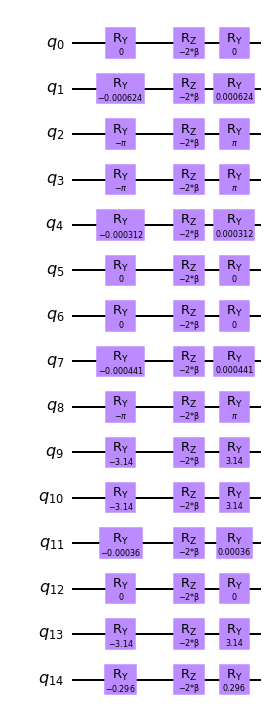

In [104]:
beta = Parameter("β")

ws_mixer = QuantumCircuit(n)
for idx, theta in enumerate(thetas):
    ws_mixer.ry(-theta, idx)
    ws_mixer.rz(-2 * beta, idx)
    ws_mixer.ry(theta, idx)

ws_mixer.draw(output="mpl")

### Final Solution

We initialize the simulator to be used from a list of available simulators in Qiskit (used the QASM simulator)

We make use of the initial quantum circuit and the mixer operator in the QAOA to find the optimal solution/ Pokemon team

Note that we only consider single type Pokemon in our team (Generation 1 Pokemon)

In [105]:
algorithm_globals.random_seed = 12345
quantum_instance = QuantumInstance(
    BasicAer.get_backend("qasm_simulator"),
    seed_simulator=algorithm_globals.random_seed,
    seed_transpiler=algorithm_globals.random_seed,
)

In [106]:
ws_qaoa_mes = QAOA(
    quantum_instance=quantum_instance,
    initial_state=init_qc,
    mixer=ws_mixer,
)

ws_qaoa = MinimumEigenOptimizer(ws_qaoa_mes)

ws_qaoa_result = ws_qaoa.solve(qp_mdl)
print(ws_qaoa_result.prettyprint())

objective function value: -13.0
variable values: normal=0.0, fire=0.0, water=1.0, electric=1.0, grass=0.0, ice=0.0, fighting=0.0, poison=0.0, ground=1.0, flying=1.0, psychic=1.0, bug=0.0, rock=0.0, ghost=1.0, dragon=0.0
status: SUCCESS


### The Optimal Pokemon team according to the QAOA results

Since we never look at specific Pokemons (only to the types) we have a little freedom to choose which ever Pokemon from the Optimal types given to us from the QAOA results

Given below is the Final team

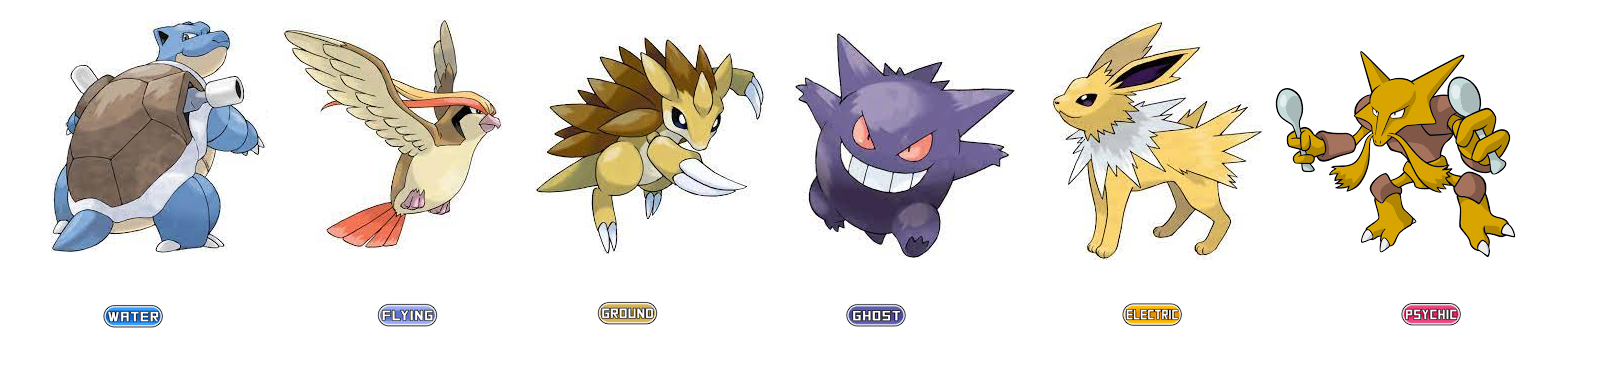